In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from top2vec import Top2Vec

In [2]:
path_corpus_tut = Path('../data/corpora/clean_tutby_126784.csv')
path_plot = Path('../data/plot/last_clean_126784.html')
path_model_top2vec = Path('../data/model/top2vec_reduced_100_clean_126784.joblibfile')
reduced = True

In [3]:
%%time

model = Top2Vec.load(path_model_top2vec)


print(model.documents.shape)
print(model.doc_top_reduced.shape)
print(model.topic_words_reduced.shape)

(126784,)
(126784,)
(100, 50)
Wall time: 4.96 s


In [4]:
%%time

n_predicted_tags = 5


data = pd.read_csv(path_corpus_tut)
data['tags'] = data['tags'].apply(eval)
data['date'] = pd.to_datetime(data['date'])

data['topic'] = model.doc_top_reduced
data['topic_words'] = model.topic_words_reduced[data['topic']][:,:n_predicted_tags].tolist()

data = data.sort_values('date')

print(data.shape)
display(data.head(5))

(126782, 8)


,url,label,header,date,document,tags,topic,topic_words
0,https://news.tut.by/550306.html,Футбол,"Тренер ""Шахтера"": Оправдываться не хочу. Все в...",2017-07-06 21:35:00+03:00,главный тренер солигорский шахтер олег кубарев...,[футбол],1,"[бате, борисовчанин, городея, еврокубок, еврок..."
3,https://news.tut.by/550309.html,Футбол,Станислав Драгун дебютировал за БАТЭ в матче с...,2017-07-06 22:11:00+03:00,чемпион беларусь бате воспользоваться пауза че...,"[футбол, БАТЭ]",1,"[бате, борисовчанин, городея, еврокубок, еврок..."
4,https://news.tut.by/550310.html,В мире,Генпрокурор Украины пообещал открыть уголовное...,2017-07-06 22:28:00+03:00,генпрокуратура украина открывать уголовный про...,"[Ситуация в Украине, государственные перевороты]",84,"[порошенко, батькивщина, саакашвили, зеленскии..."
5,https://news.tut.by/550311.html,Футбол,"""Славия"" выбыла в 1/16 Кубка Беларуси, проигра...",2017-07-06 22:48:00+03:00,аутсайдер высокий лига мозырский славия выбыва...,"[футбол, Чемпионат Беларуси по футболу]",1,"[бате, борисовчанин, городея, еврокубок, еврок..."
6,https://news.tut.by/550313.html,Теннис,Александр Бурый не вышел во 2-й раунд парного ...,2017-07-06 23:05:00+03:00,белорусский теннисист александр бурый выходить...,[теннис],53,"[ракетка, соболенко, саснович, арина, wta]"


Wall time: 13.5 s


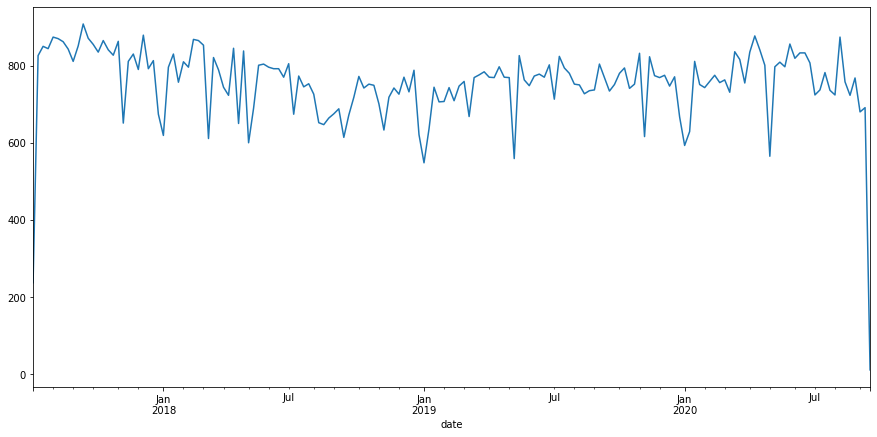

In [5]:
data.resample('W', on='date')['date'].count().plot(figsize=(15,7));

In [8]:
figure = go.Figure()

for topic in range(model.topic_words_reduced.shape[0]):
    ts_topic = data[data['topic'] == topic].resample('W', on='date')['date'].count()
    ts_entire = data.resample('W', on='date')['date'].count()[ts_topic.index]
    ts = ts_topic / ts_entire
    ts = ts[ts_entire > 100]
    if (ts.max() > 0.07):
        topic_words = model.topic_words_reduced[topic][:n_predicted_tags].tolist()
        name = ','.join(topic_words)
        figure.add_scatter(x=ts.index, y=ts, mode='lines', name=name)

figure.write_html(str(path_plot))

In [7]:
delta = pd.Timedelta(7, 'day')
last = data['date'].iloc[-1]
first = last - delta

print(first)
print(last)

data_last = data[data['date'] > first]

counts = data_last['topic'].value_counts(normalize=True)[:15]


counts_topic = pd.DataFrame()
counts_topic['counts'] = counts
counts_topic['topic'] = counts.index
counts_topic['topic_words'] = model.topic_words_reduced[counts.index][:,:5].tolist()

counts_topic

2020-09-07 13:51:00+03:00
2020-09-14 13:51:00+03:00


,counts,topic,topic_words
3,0.159443,3,"[ивс, штатское, омон, окрестин, пикетирование]"
82,0.055728,82,"[малооблачноутро, пасмурноутро, облачностьутро..."
55,0.049536,55,"[народ, искренне, уважение, патриотизм, уважать]"
12,0.030960,12,"[заражение, инфицирование, инфицированныи, cov..."
30,0.030960,30,"[цик, ермошин, центризбирком, избирательныи, е..."
39,0.021672,39,"[диалог, макеи, евросоюз, дипломатия, мид]"
0,0.018576,0,"[дтп, пдд, водитель, гаи, встречок]"
18,0.017028,18,"[полноэкранныи, fonearena, nubia, цветопередач..."
31,0.017028,31,"[привод, трансмиссия, акп, переднии, бензиновыи]"
24,0.017028,24,"[контроллер, клавиатура, воспроизводить, kupit..."
